In [211]:
# Just disables the warning, doesn't enable AVX/FMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [210]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import max_norm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import csv

In [59]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [437]:
#SPLIT DATAFRAME INTO 3 SETS
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df.index)
        train_end = int(train_percent * m)
        validate_end = int(validate_percent * m) + train_end
        train = df.iloc[perm[:train_end]]
        validate = df.iloc[perm[train_end:validate_end]]
        test = df.iloc[perm[validate_end:]]
        return train, validate, test

data = pd.read_csv("./infected_rand.csv")
data["VAL"]=data["VAL"].astype(str)

train, validate, test = train_validate_test_split(data)

In [338]:
#TRAINING GENERATOR
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
					zoom_range=0.1,
                    )

train_data_gen = image_gen_train.flow_from_dataframe(
                                                dataframe=train, 
                                                classes = ['0','1'],
                                                x_col="PATHS",
                                                y_col="VAL",
                                                class_mode='binary',  
                                                target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                )

Found 14434 validated image filenames belonging to 2 classes.


In [339]:
#VALIDATION GENERATOR
#we do not apply the data augmentation to the validation models 
image_gen_test = ImageDataGenerator(rescale=1./255 )
val_data_gen = image_gen_test.flow_from_dataframe(batch_size=batch_size,
                                                    dataframe=validate,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = ['0','1'],
                                                    x_col="PATHS",
                                                    y_col="VAL",
                                                    class_mode='binary')

Found 4811 validated image filenames belonging to 2 classes.


In [341]:
#TEST GENERATOR
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_dataframe(batch_size=batch_size,
                                                    dataframe=test,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    x_col="PATHS",
                                                    classes = ['0','1'],
                                                    y_col="VAL",
                                                    class_mode='binary')

Found 4813 validated image filenames belonging to 2 classes.


In [441]:
#CREATE THE MODEL
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3) ,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

# base_model.summary()

In [344]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [346]:
#COMPILING THE MODEL
#can view training and validation accuracy for each training epoch using the metrics arg, and uses the optimitzer ADAM 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam'),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [367]:
#FITTING THE MODEL
STEP_SIZE_TRAIN = train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID = val_data_gen.n//val_data_gen.batch_size
STEP_SIZE_TEST = test_data_gen.n//test_data_gen.batch_size

#TRAINING THE MODEL
#uses the fit_generator method of ImageDataGenerator class to train the network 
#fits the model with real-time data augmentation 
#train the model by slicing data into "batches" of size "batch size", and repeat over entire dataset for a give number of "epochs"
#history obeject will hold a record of the loss values and metric values during training 

weight = {0:1.34, 1:1}

history = model.fit(
    train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=STEP_SIZE_VALID,
    class_weight = weight
)

Epoch 1/10
451/451 [==============================] - 392s 869ms/step - loss: 0.1283 - accuracy: 0.9600 - val_loss: 0.2618 - val_accuracy: 0.9592
Epoch 2/10
451/451 [==============================] - 385s 853ms/step - loss: 0.1531 - accuracy: 0.9554 - val_loss: 0.3803 - val_accuracy: 0.8908
Epoch 3/10
451/451 [==============================] - 535s 1s/step - loss: 0.1159 - accuracy: 0.9633 - val_loss: 0.2580 - val_accuracy: 0.9168
Epoch 4/10
451/451 [==============================] - 572s 1s/step - loss: 0.1258 - accuracy: 0.9604 - val_loss: 0.2279 - val_accuracy: 0.9616
Epoch 5/10
451/451 [==============================] - 566s 1s/step - loss: 0.1173 - accuracy: 0.9613 - val_loss: 0.3895 - val_accuracy: 0.9491
Epoch 6/10
451/451 [==============================] - 688s 2s/step - loss: 0.1194 - accuracy: 0.9630 - val_loss: 0.1754 - val_accuracy: 0.9637
Epoch 7/10
451/451 [==============================] - 541s 1s/step - loss: 0.1126 - accuracy: 0.9647 - val_loss: 0.1200 - val_accuracy: 

In [434]:
# #VISUALIZING TRAINING RESULTS
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()


In [438]:
# Export the model to a SavedModel
model.save('./', save_format='tf')

INFO:tensorflow:Assets written to: ./assets


In [141]:
# # Recreate the exact same model
# model = keras.models.load_model('./')

In [184]:
# #Just to look at some batch data 
# x, y = next(test_data_gen)

In [368]:
#PREDICT THE OUTPUT 
#want to check if the accuracy on test data set performs the same as on the training 
test_loss, test_acc = model.evaluate (test_data_gen, steps=STEP_SIZE_TEST, verbose=1)

37/37 [==============================] - 66s 2s/step - loss: 0.1118 - accuracy: 0.9685


In [411]:
#create probability model that uses softmax for easier to interpret output
probability_model = tf.keras.Sequential([model,  tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_data_gen, steps=STEP_SIZE_TEST, verbose=1)

37/37 [==============================] - 64s 2s/step


In [432]:
# predictions

In [420]:
paths = test["PATHS"].tolist()
vals = test["VAL"].tolist()
pred = predictions.tolist()

In [430]:
# #count the number of accurates vs non-accurates 
# acc = {"accurate":0, "not_accurate": 0}

# i=0
# for p in predictions:
#         if (p[0] > p[1]):
#             if (vals[i] == '0'):
#                 acc["accurate"] +=1
#             else:
#                 acc["not_accurate"]+=1
                
#         elif(p[1] > p[0]):
#             if (vals[i] == '1'):
#                 acc["accurate"] +=1
#             else:
#                 acc["not_accurate"]+=1

#         i+=1
        
# print("Accurate: {}".format(acc["accurate"]))
# print("Not Accurate: {}".format(acc["not_accurate"]))


In [428]:
# #count the number of calculated 0s and 1s 
# num = {0:0, 1: 0}
# for val in predictions:
#         if (val[0] > val[1]):
#             num[0] += 1
#         elif(val[1] > val[0]):
#             num[1]+=1

# print("Predicted:")
# print(f"Number of 0s: {num[0]}")
# print(f"Number of 1s: {num[1]}")
# print("\n")

# numOriginal = {0:0, 1: 0}
# for val in vals:
#     if (val == '0'):
#         numOriginal[0]+=1
#     if (val == '1'):
#         numOriginal[1]+=1

# print("Originally:")
# print(f"Number of 0s: {numOriginal[0]}")
# print(f"Number of 1s: {numOriginal[1]}")

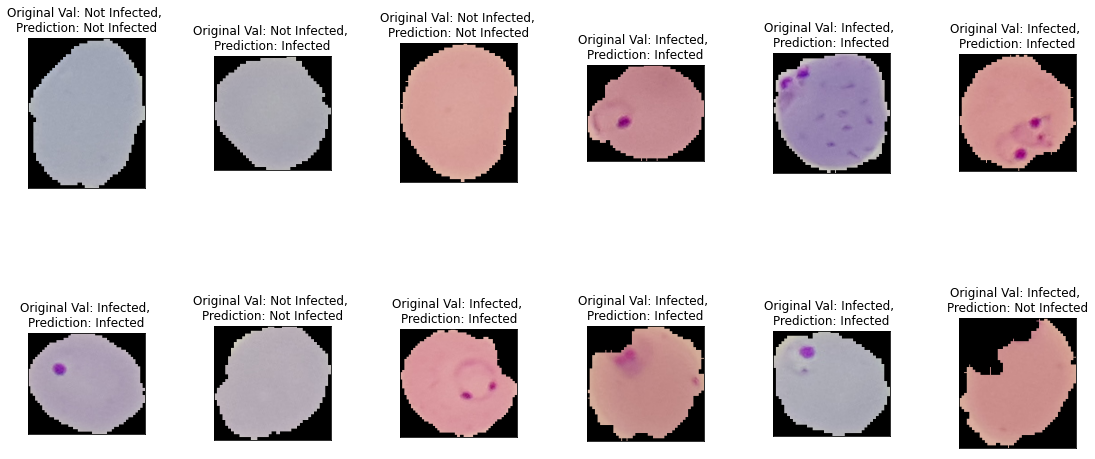

In [439]:
rows = 2
columns = 6

#starts
#0 - ok
#15 - big yikes
#150 - ehh
#750 - not bad, if you just take the first two rows 

a=rows*columns

start = 750 #starting index 
end = start+a #end index 

i=start #let i be an iterator 

fig, ax = plt.subplots(rows, columns, figsize = (16, 8)) 
fig.tight_layout(pad=3.5)
plt.setp(ax, xticks=[],yticks=[])

labels0 = []
labels1 = []
for val in predictions:
        labels0.append(val[0])
        labels1.append(val[1])
    
for x in range (0, rows):
    for y in range (0, columns):
        path = paths[i]
        val = vals[i]
        img = mpimg.imread(path)
        ax[x,y].imshow(img)
#         ax[x,y].set_title("Original Val: {}, \nNot-Infected(0): {:.3f}, \nInfected(1): {:.3f}:" .format("Infected" if val=='1' else 'Not Infected', labels0[i], labels1[i] ))
        ax[x,y].set_title("Original Val: {}, \nPrediction: {}" .format("Infected" if val=='1' else 'Not Infected', "Infected" if labels0[i]<labels1[i] else 'Not Infected'))
        i +=1
        

In [433]:
# test["PATHS"].iloc[1]